# Traveling Salesman Problem using Variants of Quantum Approximate Optimization Algorithm (QAOA), a small illustration of QiboOpt

## Traveling Salesman Problem

The **Traveling Salesman Problem (TSP)** is one of the most famous problems in combinatorial optimization. It can be stated as follows:

> Given a list of cities and the distances between each pair of cities, the goal is to find the **shortest possible route** that visits each city **exactly once** and returns to the starting city.

**Key Points:**

1. **Combinatorial Nature:** For $n$ cities, there are $(n-1)!$ possible routes (since the starting city can be fixed). This grows factorially, making TSP computationally hard for large $n$.  

2. **Applications:** TSP is not just theoretical, it appears in logistics, vehicle routing, circuit design, and even DNA sequencing.  

3. **Optimization Goal:** We aim to minimize the **total travel distance** (or cost) of the tour.



Here is a $3$-city example where we have to decide which direction to travel to minimize the cost. We consider the following distance matrices

$$
\mathbf{D} =
\begin{bmatrix}
0 & 0.9 & 0.8 \\
0.4 & 0 & 0.1 \\
0.5 & 0.7 & 0
\end{bmatrix}
$$

where the $(i,j)$ entry of the distance matrix indicates the travel distance from city $i$ to city $j$. Notice that the distance matrix does not need to  be symmetrical. Let's visualize the two possible directions.

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

dist_matrix = np.array([
    [0, 0.9, 0.8],
    [0.4, 0, 0.1],
    [0.5, 0.7, 0]
])

In [3]:
_THEMES = {
    "light": {
        "fig_bg":       "#ffffff",
        "axes_bg":      "#f8f9fa",
        "axes_edge":    "#dee2e6",
        "label":        "#343a40",
        "tick":         "#495057",
        "text":         "#212529",
        "grid":         "#dee2e6",
        "cell_header":  "#e9ecef",
        "cell_header_text": "#495057",
        "cell_even":    "#ffffff",
        "cell_odd":     "#f8f9fa",
        "cell_text":    "#212529",
        "cell_edge":    "#dee2e6",
        "legend_bg":    "#ffffff",
        "legend_edge":  "#dee2e6",
        "legend_text":  "#343a40",
        "annot_lo":     "#212529",   # text color on low-intensity heatmap cell
        "annot_hi":     "#ffffff",   # text color on high-intensity heatmap cell
        "heatmap_lo":   "#ffffff",
        "heatmap_hi":   "#0077b6",
        "opt_false":    "#dee2e6",
        "opt_true":     "#0077b6",
        "opt_text_true":  "#ffffff",
        "opt_text_false": "#495057",
    },
    "dark": {
        "fig_bg":       "#0b1120",
        "axes_bg":      "#0b1120",
        "axes_edge":    "#1e293b",
        "label":        "#94a3b8",
        "tick":         "#64748b",
        "text":         "#e2e8f0",
        "grid":         "#1e293b",
        "cell_header":  "#1e293b",
        "cell_header_text": "#94a3b8",
        "cell_even":    "#0f172a",
        "cell_odd":     "#0b1120",
        "cell_text":    "#cbd5e1",
        "cell_edge":    "#1e293b",
        "legend_bg":    "#0f172a",
        "legend_edge":  "#1e293b",
        "legend_text":  "#94a3b8",
        "annot_lo":     "#e2e8f0",
        "annot_hi":     "#0b1120",
        "heatmap_lo":   "#0b1120",
        "heatmap_hi":   "#22d3ee",
        "opt_false":    "#1e293b",
        "opt_true":     "#22d3ee",
        "opt_text_true":  "#0b1120",
        "opt_text_false": "#94a3b8",
    },
}

TOUR_COLORS_LIGHT = {"(0, 1, 2)": "#0077b6", "(0, 2, 1)": "#c1121f"}
TOUR_COLORS_DARK  = {"(0, 1, 2)": "#22d3ee", "(0, 2, 1)": "#f472b6"}

PENALTY_COLORS_LIGHT = {1.9: "#6a4c93", 2.9: "#1a7431", 3.9: "#d4620a"}
PENALTY_COLORS_DARK  = {1.9: "#818cf8", 2.9: "#34d399", 3.9: "#fb923c"}

OPTIMAL_TOUR   = "(0, 1, 2)"
OPTIMAL_LENGTH = 1.5

# ── active theme (set at import time, can be overridden) ─────────────────────

def _detect_theme():
    """
    Infer light vs dark from the current rcParams background color.
    Treats any color with luminance < 0.5 as dark.
    """
    bg = plt.rcParams.get("figure.facecolor", "white")
    try:
        r, g, b, *_ = mcolors.to_rgba(bg)
        luminance = 0.299 * r + 0.587 * g + 0.114 * b
        return "dark" if luminance < 0.5 else "light"
    except ValueError:
        return "light"


_active_theme = _detect_theme()


def set_theme(name: str):
    """
    Manually force a theme.  Call before any plot functions.
      set_theme("light")   # default Jupyter
      set_theme("dark")    # JupyterLab dark / VS Code dark
    """
    global _active_theme
    assert name in _THEMES, f"theme must be 'light' or 'dark', got {name!r}"
    _active_theme = name


def _T():
    """Return the active theme dict."""
    return _THEMES[_active_theme]


def _tour_colors():
    return TOUR_COLORS_LIGHT if _active_theme == "light" else TOUR_COLORS_DARK


def _penalty_colors():
    return PENALTY_COLORS_LIGHT if _active_theme == "light" else PENALTY_COLORS_DARK


def _apply_rcparams():
    T = _T()
    plt.rcParams.update({
        "figure.facecolor": T["fig_bg"],
        "axes.facecolor":   T["axes_bg"],
        "axes.edgecolor":   T["axes_edge"],
        "axes.labelcolor":  T["label"],
        "xtick.color":      T["tick"],
        "ytick.color":      T["tick"],
        "text.color":       T["text"],
        "grid.color":       T["grid"],
        "grid.linestyle":   "--",
        "font.family":      "monospace",
        "axes.titlecolor":  T["text"],
        "axes.titlesize":   11,
    })

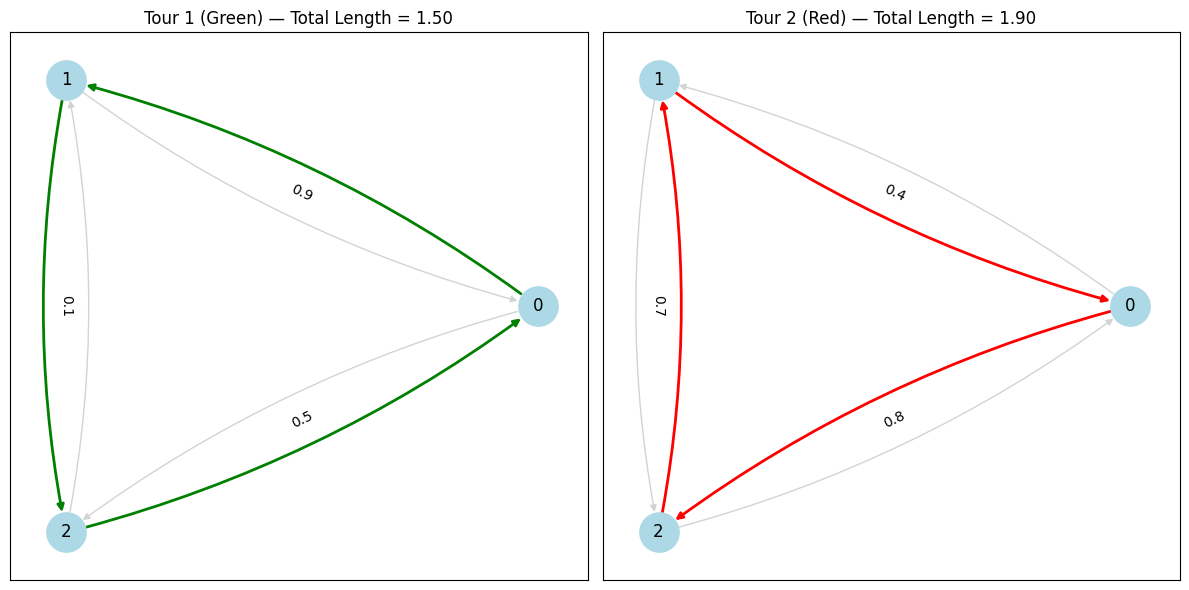

In [4]:
# Build directed graph
G = nx.DiGraph()
n = len(dist_matrix)
for i in range(n):
    for j in range(n):
        if dist_matrix[i, j] > 0:
            G.add_edge(i, j, weight=dist_matrix[i, j])

# Two tours
tour1 = [(0, 1), (1, 2), (2, 0)]
tour2 = [(0, 2), (2, 1), (1, 0)]

# Compute total lengths
tour1_length = sum(dist_matrix[i, j] for i, j in tour1)
tour2_length = sum(dist_matrix[i, j] for i, j in tour2)

pos = nx.circular_layout(G)  # nice circular layout

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# --- Tour 1 in green ---
ax = axes[0]
nx.draw_networkx_edges(G, pos, ax=ax, edge_color="lightgray", arrows=True,
                       connectionstyle="arc3,rad=0.1", arrowstyle='-|>', min_source_margin=15, min_target_margin=15)
nx.draw_networkx_edges(G, pos, edgelist=tour1, ax=ax,
                       edge_color="green", width=2, arrows=True,
                       connectionstyle="arc3,rad=0.1", arrowstyle='-|>', min_source_margin=15, min_target_margin=15)
nx.draw_networkx_nodes(G, pos, ax=ax, node_color="lightblue", node_size=800)
nx.draw_networkx_labels(G, pos, ax=ax, font_size=12, font_color="black")
edge_labels = {(i, j): f"{dist_matrix[i, j]:.1f}" for i, j in tour1}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax, font_size=10)
ax.set_title(f"Tour 1 (Green) — Total Length = {tour1_length:.2f}")

# --- Tour 2 in red ---
ax = axes[1]
nx.draw_networkx_edges(G, pos, ax=ax, edge_color="lightgray", arrows=True,
                       connectionstyle="arc3,rad=0.1", arrowstyle='-|>', min_source_margin=15, min_target_margin=15)
nx.draw_networkx_edges(G, pos, edgelist=tour2, ax=ax,
                       edge_color="red", width=2, arrows=True,
                       connectionstyle="arc3,rad=0.1", arrowstyle='-|>', min_source_margin=15, min_target_margin=15)
nx.draw_networkx_nodes(G, pos, ax=ax, node_color="lightblue", node_size=800)
nx.draw_networkx_labels(G, pos, ax=ax, font_size=12, font_color="black")
edge_labels = {(i, j): f"{dist_matrix[i, j]:.1f}" for i, j in tour2}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax, font_size=10)
ax.set_title(f"Tour 2 (Red) — Total Length = {tour2_length:.2f}")

plt.tight_layout()
plt.show()

TOUR_COLORS    = {"(0, 1, 2)": "#22d3ee", "(0, 2, 1)": "#f472b6"}
PENALTY_COLORS = {1.9: "#818cf8", 2.9: "#34d399", 3.9: "#fb923c"}
OPTIMAL_TOUR   = "(0, 1, 2)"
OPTIMAL_LENGTH = 1.5

def _unique_sorted(results_list, key):
    return sorted(set(d[key] for d in results_list))


def _build_pivot(results_list, penalties, layers, field):
    """
    Returns a 2-D list  pivot[r][c]  where
      r = index into `penalties`, c = index into `layers`.
    """
    lookup = {(d["penalty"], d["layer"]): d[field] for d in results_list}
    return [[lookup.get((pen, lay)) for lay in layers] for pen in penalties]


We will prefer Tour 1 as the distance is smaller than Tour 2. 

In this tutorial, we will showcase a small instance of 3 cities problem and show that we can determine the right direction to travel. This is just a proof of concept of how to formulate TSP in a form that can be attempted using a quantum optimisation algorithm known as Quantum Approximate Optimization Algorithm (QAOA). 

## Encoding of the length of the tour as a Quadratic Unconstrained Binary Optimisation (QUBO) Problem

The length of a tour can be encoded as a Quadratic Unconstrained Binary Optimisation (QUBO) problem. A common encoding is as follows, consider an $n$-city problem, we prepare $n$ slots that will determine the order in which we visit the cities. 

We then use a one-hot encoding of $x_{ui}=1$ if city $u$ is assigned to slot $i$, otherwise we have $x_{ui}=0$ if city $u$ is not assigned to slot $i$. We let $$d_{u,v}$$ represent the distance.

Given an encoding of a valid tour, the length of the tour can be described as 

$$\sum_{i=0}^{n-1}  \sum_{u=0}^{n-1}\sum_{v=0}^{n-1}d_{u,v}x_{u,i}x_{v, i+1 \pmod{n}}.$$

It is summing up the the distance of cities that are visited consecutively.

Using the technique developed by Hadfield [4],  quantum alternating operator ansatz algorithm can be used to solve this TSP instance provided it begins with a feasible solution. Both this encoding and the technique used to ensure feasibility remains has been implemented in the TSP class that we can simply import using `from qiboopt.combinatorial.combinatorial import TSP` and we just have to provide the distance function to the function `TSP`. 

In [11]:
from qiboopt.combinatorial.combinatorial import TSP
import numpy as np
from collections import defaultdict
from qibo import gates
from qibo.models import QAOA
from qibo.result import CircuitResult
from qibo.models.circuit import Circuit

def _plot_shot_histogram(cauchy_dict, feasibility):
    _apply_rcparams()
    T = _T()
    TC = _tour_colors()
    
    tours  = [str(k) for k in cauchy_dict]
    counts = list(cauchy_dict.values())
    colors = [TC.get(t, T["tick"]) for t in tours]

    fig, ax = plt.subplots(figsize=(5, 3), facecolor=T["fig_bg"])
    ax.set_facecolor(T["axes_bg"])
    bars = ax.bar(tours, counts, color=colors, edgecolor=T["fig_bg"],
                  linewidth=0.8, zorder=3)
    ax.set_title(f"Shot Histogram   (feasibility {feasibility*100:.1f} %)", pad=10)
    ax.set_ylabel("Counts")
    ax.set_xlabel("Tour")
    ax.yaxis.grid(True, zorder=0)
    ax.set_axisbelow(True)

    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
                str(count), ha="center", va="bottom", fontsize=9, color=T["label"])

    handles = [Patch(facecolor=TC.get(t, T["tick"]), label=t,
                     edgecolor=T["axes_edge"]) for t in tours]
    ax.legend(handles=handles, fontsize=8, facecolor=T["legend_bg"],
              edgecolor=T["legend_edge"], labelcolor=T["legend_text"])
    plt.tight_layout()
    plt.show()


def check_feasibility(config):
    """
    check if a configuration is feasible
    """
    m = int(np.sqrt(len(config)))
    for i in range(m):
        row_sum = 0
        for j in range(m):
            row_sum += int(config[m*i+j])
        if row_sum != 1:
                return False
    for j in range(m):
        col_sum = 0
        for i in range(m):
            col_sum += int(config[m*i+j])
        if col_sum != 1:
            return False
    return True
    
def convert_to_standard_Cauchy(config):
    """
    Given a binary string of n^2, we convert it to an order of 0, 1, ..., n-1
    """
    m = int(np.sqrt(len(config)))
    cauchy = [-1] * m  # Cauchy's notation for permutation, e.g. (1,2,0) or (2,0,1)
    for i in range(m):
        for j in range(m):
            if config[m * i + j] == '1':
                cauchy[j] = i  # citi i is in slot j
    for i in range(m):
        if cauchy[i] == 0:
            cauchy = cauchy[i:] + cauchy[:i]
            return tuple(cauchy)
            # now, the cauchy notation for permutation begins with 0


def evaluate_dist(cauchy):
    '''
    Given a permutation of 0 to n-1, we compute the distance of the tour

    '''
    m = len(cauchy)
    return sum(distance_matrix[cauchy[i]][cauchy[(i+1)%m]] for i in range(m))


def find_mode_from_result(freq_counter, plot: bool=True):
    # let's combine freq_counter here, first convert each key and sum up the frequency
    cauchy_dict = defaultdict(int)
    feasibility_counter = 0
    freq_counter_len = 0
    feasibility = 0
    for freq_key in freq_counter:
        freq_counter_len += freq_counter[freq_key]
        if check_feasibility(freq_key):
            standard_cauchy_key = convert_to_standard_Cauchy(freq_key)
            cauchy_dict[standard_cauchy_key] += freq_counter[freq_key]
            feasibility += freq_counter[freq_key]
    if feasibility == 0:
        print("warning, no solution is feasible")
        return None, None, 0
    max_key = max(cauchy_dict, key=cauchy_dict.get)
    tour_dist = evaluate_dist(max_key)
    feasibility /= freq_counter_len
    
    star = " ★ optimal" if str(max_key) == OPTIMAL_TOUR else ""
    print(f"  Mode tour   : {max_key}{star}")
    print(f"  Tour length : {tour_dist}")
    print(f"  Feasibility : {feasibility*100:.1f} %")
    if plot and cauchy_dict:
        _plot_shot_histogram(cauchy_dict, feasibility)
    return max_key, evaluate_dist(max_key), feasibility, cauchy_dict
    

def qaoa_function_of_layer(layer, distance_matrix, plot=True):
    '''
    This is a function to study the impact of the number of layers on QAOA,
    it takes in the number of layers and compute the distance of the mode
    of the histogram obtained from QAOA

    '''
    small_tsp = TSP(distance_matrix)
    obj_hamil, mixer = small_tsp.hamiltonians()
    qaoa = QAOA(obj_hamil, mixer=mixer)
    best_energy, final_parameters, extra = qaoa.minimize(initial_p=[0.1] * layer,
                                         initial_state=initial_state, method='BFGS')
    qaoa.set_parameters(final_parameters)
    quantum_state = qaoa.execute(initial_state)
    circuit = Circuit(9)
    circuit.add(gates.M(*range(9)))
    result = CircuitResult(quantum_state, circuit.measurements,
            small_tsp.backend, nshots=1000)
    freq_counter = result.frequencies()
    return find_mode_from_result(freq_counter, plot) 

np.random.seed(42)
num_cities = 3
distance_matrix = dist_matrix
distance_matrix = distance_matrix.round(1)
small_tsp = TSP(distance_matrix)
initial_parameters = np.random.uniform(0, 1, 2)
initial_state = small_tsp.prepare_initial_state([i for i in range(num_cities)])
ans = qaoa_function_of_layer(2, distance_matrix, False)

  Mode tour   : (0, 1, 2) ★ optimal
  Tour length : 1.5
  Feasibility : 100.0 %


Another approach that we can use is the penalty method where we have to set a penalty coefficient. 

The constraints can be described mathematically as

$$\sum_{i} x_{ui}=1, \forall u \in \{0, \ldots, n-1\}$$

and 

$$\sum_{u} x_{ui}=1, \forall i \in \{0, \ldots, n-1\}$$

which means each city is allocated to exactly one slot and each slot is allocated to exactly one city. 

Using the penalty method, the modified objective function is as follows:

$$\sum_{i=0}^{n-1}\sum_{u=0}^{n-1}\sum_{v=0}^{n-1}  d_{u, v}x_{u,i}x_{v, (i+1)\pmod{n}} + P \left( \sum_{u=0}^{n-1} \left( \sum_{i=0}^{n-1} x_{ui}-1\right)^2 +\sum_{i=0}^{n-1} \left( \sum_{u=0}^{n-1} x_{ui}-1\right)^2 \right)$$

Users just have to provide the value of $P$ for a TSP class instance to generate QAOA [2] and XQAOA [5] circuits. 

It suffices to set $P > \max_{u,v} d_{u,v}$.

Below is the code to generate a QUBO with the penalty method, after which, we show various alternatives that are available for us to attempt the instance.


In [12]:
def plot_penalty_summary(results_list):
    """
    Four-panel figure (pure matplotlib + numpy, no pandas / seaborn):
      A  Feasibility heatmap  (penalty x layer)
      B  Feasibility % vs layers, one line per penalty
      C  Optimal-tour binary heatmap
      D  Styled summary table
    """
    _apply_rcparams()
    T = _T()
    TC = _tour_colors()
    PC = _penalty_colors()
    
    penalties = _unique_sorted(results_list, "penalty")
    layers    = _unique_sorted(results_list, "layer")
    n_pen     = len(penalties)
    n_lay     = len(layers)

    feas_grid = np.array(
        _build_pivot(results_list, penalties, layers, "feasibility"), dtype=float
    )                                               # shape (n_pen, n_lay)
    tour_grid = _build_pivot(results_list, penalties, layers, "tour")  # 2-D list[str]
    opt_grid  = np.array(
        [[1 if t == OPTIMAL_TOUR else 0 for t in row] for row in tour_grid],
        dtype=float,
    )

    # ── figure layout ────────────────────────────────────────────────────────
    fig = plt.figure(figsize=(14, 9), facecolor=T["fig_bg"])
    fig.suptitle("QAOA · TSP Penalty-Method Analysis",
                 fontsize=15, fontweight="bold", color="#e2e8f0", y=0.98)

    gs       = gridspec.GridSpec(2, 3, figure=fig, hspace=0.45, wspace=0.38)
    ax_heat  = fig.add_subplot(gs[0, 0])
    ax_line  = fig.add_subplot(gs[0, 1])
    ax_opt   = fig.add_subplot(gs[0, 2])
    ax_table = fig.add_subplot(gs[1, :])

    # ── A: feasibility heatmap ───────────────────────────────────────────────
    cmap_feas = mcolors.LinearSegmentedColormap.from_list(
        "feas", [T["heatmap_lo"], T["heatmap_hi"]])
    im = ax_heat.imshow(feas_grid, cmap=cmap_feas, aspect="auto",
                        vmin=0, vmax=feas_grid.max())
    plt.colorbar(im, ax=ax_heat, shrink=0.8,
                 format=lambda x, _: f"{x:.0%}")
    ax_heat.set_xticks(range(n_lay))
    ax_heat.set_xticklabels(layers)
    ax_heat.set_yticks(range(n_pen))
    ax_heat.set_yticklabels(penalties)
    for r in range(n_pen):
        for c in range(n_lay):
            v      = feas_grid[r, c]
            is_opt = tour_grid[r][c] == OPTIMAL_TOUR
            label  = f"{v:.1%}" + (" ★" if is_opt else "")
            txt_col = T["annot_hi"] if v > feas_grid.max() * 0.5 else T["annot_lo"]
            ax_heat.text(c, r, label, ha="center", va="center",
                         fontsize=8, color=txt_col, fontweight="bold")
    ax_heat.set_title("Feasibility  (penalty x layer)")
    ax_heat.set_xlabel("QAOA Layers")
    ax_heat.set_ylabel("Penalty")
    ax_heat.tick_params(left=False, bottom=False)

    # ── B: line chart ────────────────────────────────────────────────────────
    for r, pen in enumerate(penalties):
        ax_line.plot(layers, feas_grid[r, :] * 100,
                     marker="o", markersize=6, linewidth=2,
                     color=PC.get(pen, T["label"]),
                     label=f"penalty={pen}")
    ax_line.set_title("Feasibility % vs Layers")
    ax_line.set_xlabel("QAOA Layers")
    ax_line.set_ylabel("Feasibility (%)")
    ax_line.set_xticks(layers)
    ax_line.legend(fontsize=8, facecolor=T["legend_bg"], edgecolor=T["legend_edge"],
                   labelcolor=T["legend_text"])
    ax_line.yaxis.grid(True)

    # ── C: optimal-tour binary heatmap ──────────────────────────────────────
    cmap_bin = mcolors.ListedColormap([T["opt_false"], T["opt_true"]])
    ax_opt.imshow(opt_grid, cmap=cmap_bin, aspect="auto", vmin=0, vmax=1)
    ax_opt.set_xticks(range(n_lay))
    ax_opt.set_xticklabels(layers)
    ax_opt.set_yticks(range(n_pen))
    ax_opt.set_yticklabels(penalties)
    for r in range(n_pen):
        for c in range(n_lay):
            tour   = tour_grid[r][c]
            is_opt = opt_grid[r, c] == 1
            ax_opt.text(c, r, ("★ " if is_opt else "") + tour,
                        ha="center", va="center", fontsize=7,
                        color=T["opt_text_true"] if is_opt else T["opt_text_false"],
                        fontweight="bold" if is_opt else "normal")
    ax_opt.set_title("Mode Tour  (★ = optimal)")
    ax_opt.set_xlabel("QAOA Layers")
    ax_opt.set_ylabel("Penalty")
    ax_opt.tick_params(left=False, bottom=False)

    # ── D: summary table ─────────────────────────────────────────────────────
    ax_table.axis("off")
    col_labels = ["Penalty", "Layers", "Mode Tour", "Length", "Feasibility"]
    cell_text  = [
        [str(d["penalty"]), str(d["layer"]), str(d["tour"]),
         f"{d['obj']:.1f}", f"{d['feasibility']:.1%}"]
        for d in results_list
    ]

    tbl = ax_table.table(
        cellText=cell_text,
        colLabels=col_labels,
        cellLoc="center",
        loc="center",
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1, 1.6)

    for j in range(len(col_labels)):
        tbl[(0, j)].set_facecolor(T["cell_header"])
        tbl[(0, j)].set_text_props(color=T["cell_header_text"], fontweight="bold")

    for i, row_data in enumerate(cell_text, start=1):
        tour_str = row_data[2]
        row_bg   = T["cell_even"] if i % 2 == 0 else T["cell_odd"]
        for j in range(len(col_labels)):
            cell = tbl[(i, j)]
            cell.set_facecolor(row_bg)
            cell.set_edgecolor(T["cell_edge"])
            if j == 2:  # tour column
                cell.set_text_props(
                    color=TC.get(tour_str, T["cell_text"]),
                    fontweight="bold" if tour_str == OPTIMAL_TOUR else "normal",
                )
            else:
                cell.set_text_props(color=T["cell_text"])

    ax_table.set_title("Full Results", pad=8, color=T["text"], fontsize=11)
    plt.show()



 -- penalty = 1.9 layer = 2 --
  Mode tour   : (0, 1, 2) ★ optimal
  Tour length : 1.5
  Feasibility : 2.2 %


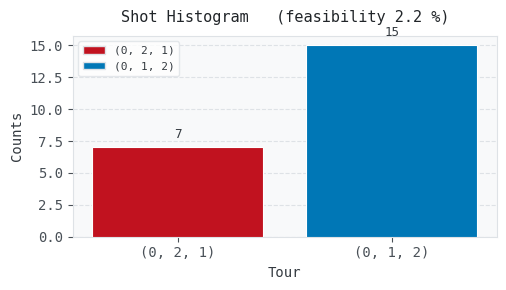


 -- penalty = 1.9 layer = 3 --
  Mode tour   : (0, 2, 1)
  Tour length : 1.9
  Feasibility : 3.7 %


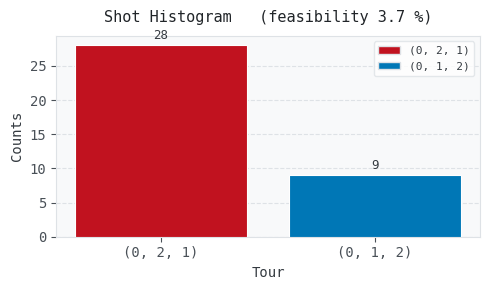


 -- penalty = 1.9 layer = 4 --
  Mode tour   : (0, 2, 1)
  Tour length : 1.9
  Feasibility : 6.5 %


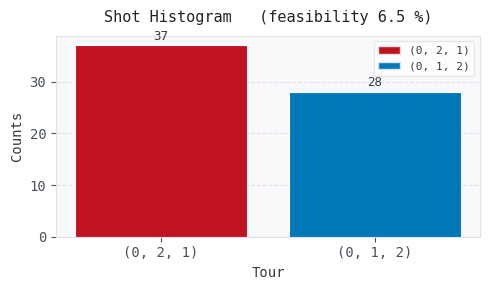


 -- penalty = 2.9 layer = 2 --
  Mode tour   : (0, 2, 1)
  Tour length : 1.9
  Feasibility : 3.9 %


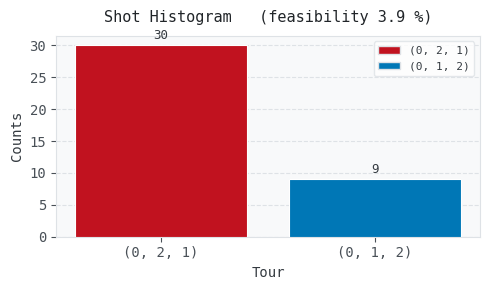


 -- penalty = 2.9 layer = 3 --
  Mode tour   : (0, 2, 1)
  Tour length : 1.9
  Feasibility : 2.4 %


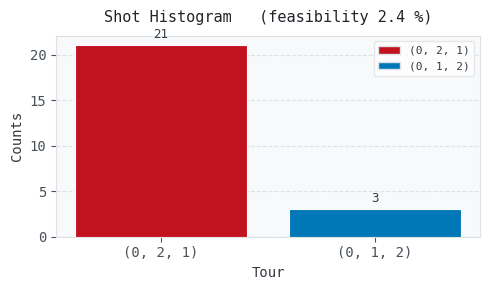


 -- penalty = 2.9 layer = 4 --
  Mode tour   : (0, 2, 1)
  Tour length : 1.9
  Feasibility : 1.4 %


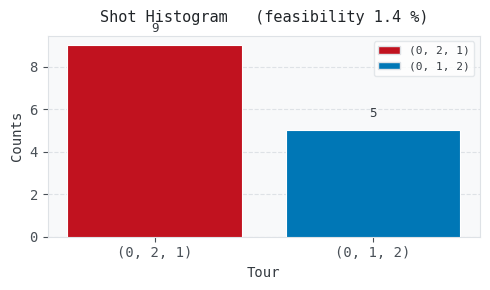


 -- penalty = 3.9 layer = 2 --
  Mode tour   : (0, 2, 1)
  Tour length : 1.9
  Feasibility : 10.0 %


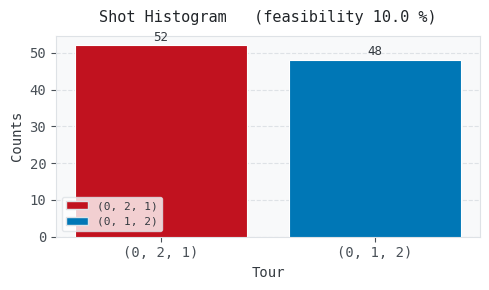


 -- penalty = 3.9 layer = 3 --
  Mode tour   : (0, 1, 2) ★ optimal
  Tour length : 1.5
  Feasibility : 7.4 %


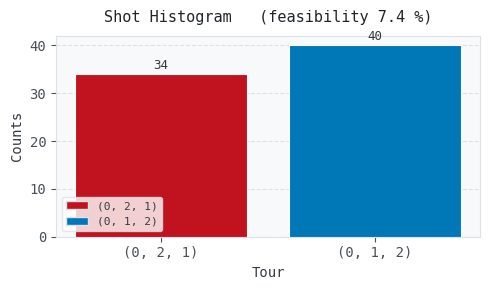


 -- penalty = 3.9 layer = 4 --
  Mode tour   : (0, 1, 2) ★ optimal
  Tour length : 1.5
  Feasibility : 2.7 %


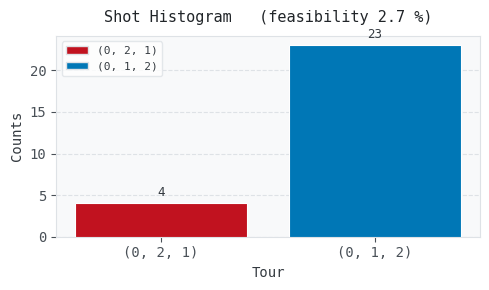

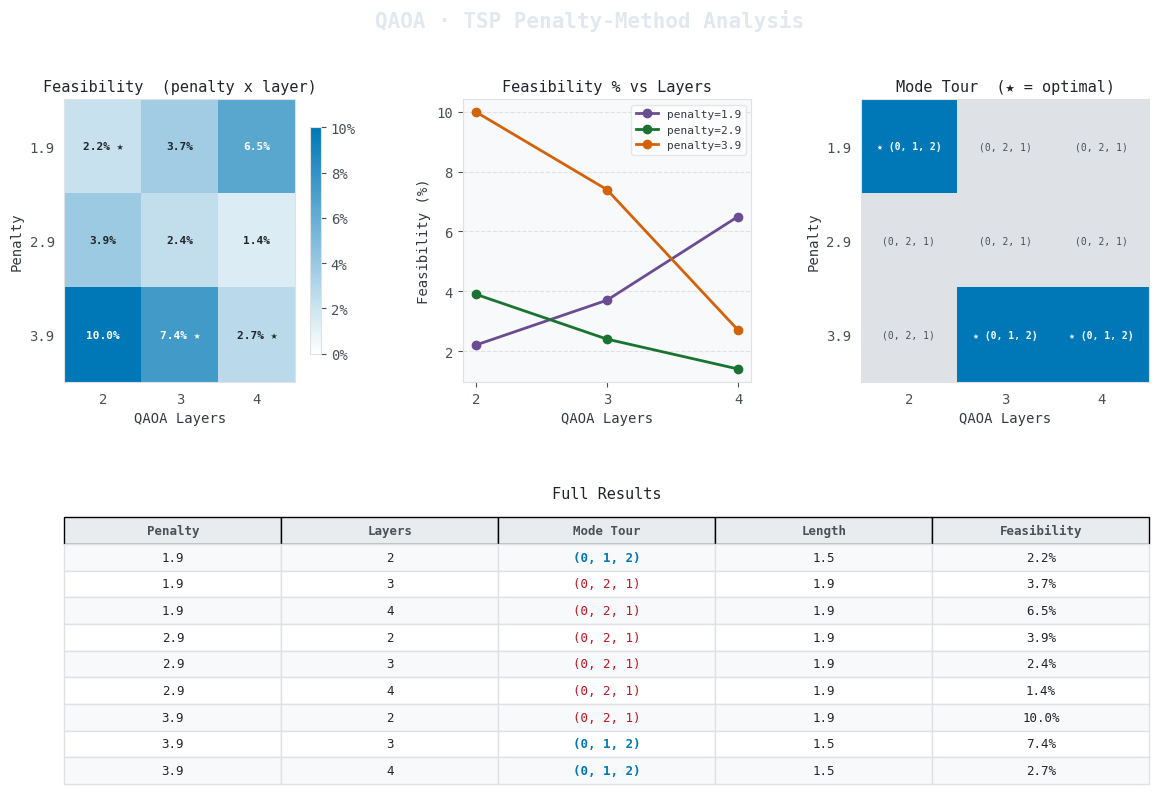

In [13]:
penalty_qaoa_feasibility_dict = dict()
results_list = []

for penalty_pert in range(1,4):
    penalty  = dist_matrix.max() + penalty_pert
    TSP_with_penalty =  small_tsp.penalty_method(penalty)
    for layer in range(2, 5):
        print(f"\n -- penalty = {penalty} layer = {layer} --")
        gammas = np.random.rand(layer)
        betas = np.random.rand(layer)
        output = TSP_with_penalty.train_QAOA(gammas=gammas, betas=betas)
        output_freq = output[-1]
        cycle, obj, prob_feasibility, cauchy_dict = find_mode_from_result(output_freq)
        results_list.append({
               "penalty":     penalty,
               "layer":       layer,
               "tour":        str(cycle),
               "obj":         obj,
               "feasibility": prob_feasibility,
               "histogram":   dict(cauchy_dict),
           })
        penalty_qaoa_feasibility_dict[(penalty, layer)] =  prob_feasibility
plot_penalty_summary(results_list)

Another alternative that we can consider is via XQAOA approach that increases expressibility by having more parameters.  To do so, we just have to provide an additional parameter alphas to the train_QAOA method and the results are as follows:


 -- penalty = 1000.9 layer = 2 --
  Mode tour   : (0, 2, 1)
  Tour length : 1.9
  Feasibility : 2.6 %


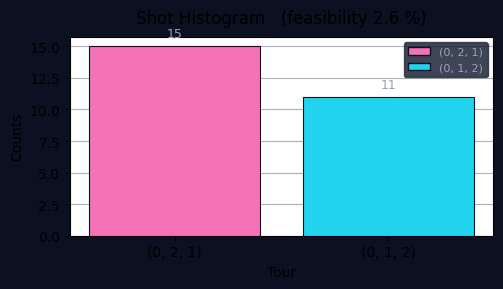


 -- penalty = 1000.9 layer = 3 --
  Mode tour   : (0, 1, 2) ★ optimal
  Tour length : 1.5
  Feasibility : 3.2 %


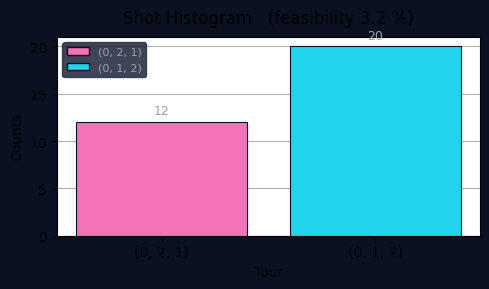


 -- penalty = 1000.9 layer = 4 --
  Mode tour   : (0, 2, 1)
  Tour length : 1.9
  Feasibility : 1.6 %


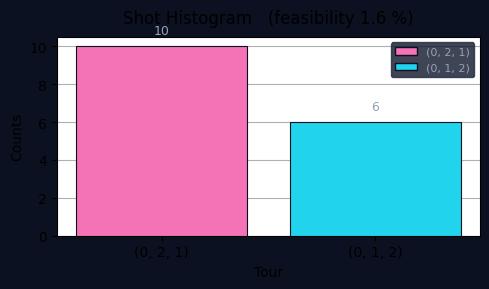

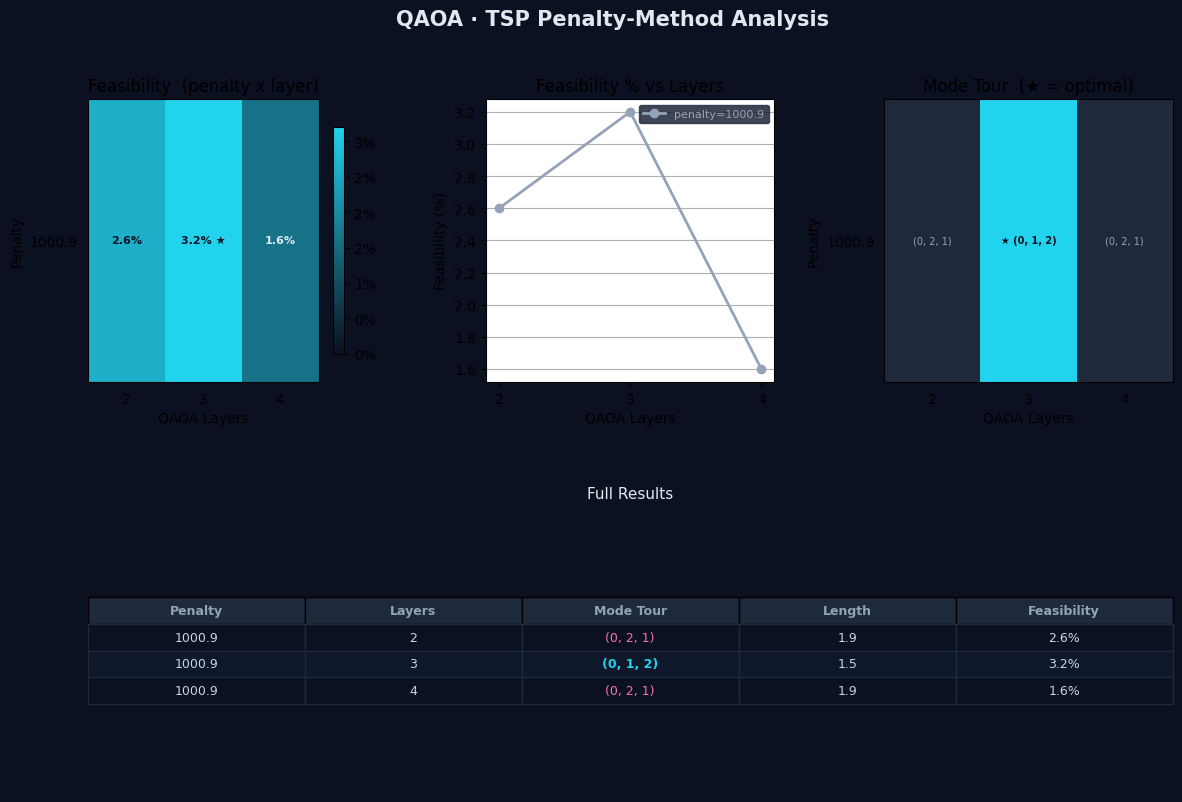

In [8]:
penalty_qaoa_feasibility_dict = dict()
results_list = []

for penalty_pert in range(1000,1001):
    penalty  = dist_matrix.max() + penalty_pert
    TSP_with_penalty =  small_tsp.penalty_method(penalty)
    for layer in range(2, 5):
        print(f"\n -- penalty = {penalty} layer = {layer} --")
        gammas = np.random.rand(layer)
        betas = np.random.rand(layer)
        output = TSP_with_penalty.train_QAOA(gammas=gammas, betas=betas)
        output_freq = output[-1]
        cycle, obj, prob_feasibility, cauchy_dict = find_mode_from_result(output_freq)
        results_list.append({
               "penalty":     penalty,
               "layer":       layer,
               "tour":        str(cycle),
               "obj":         obj,
               "feasibility": prob_feasibility,
               "histogram":   dict(cauchy_dict),
           })
        penalty_qaoa_feasibility_dict[(penalty, layer)] =  prob_feasibility
plot_penalty_summary(results_list)

In [6]:
penalty_qaoa_feasibility_xqaoa_dict = dict()
print("penalty, layer, tour, obj, prob_feasibility, result")
for penalty_pert in range(1,4):
    penalty  = dist_matrix.max() + penalty_pert
    TSP_with_penalty =  small_tsp.penalty_method(penalty)
    for layer in range(2, 5):
        alphas = np.random.rand(layer)
        gammas = np.random.rand(layer)
        betas = np.random.rand(layer)
        output = TSP_with_penalty.train_QAOA(gammas=gammas, betas=betas, alphas=alphas)
        output_freq = output[-1]
        cycle, obj, prob_feasibility, cauchy_dict = find_mode_from_result(output_freq)
        print(penalty, layer, cycle, obj, prob_feasibility, cauchy_dict)
        penalty_qaoa_feasibility_xqaoa_dict[(penalty, layer)] =  prob_feasibility

penalty, layer, tour, obj, prob_feasibility, result
Optimal tour found is (0, 1, 2)
Optimal tour length is 1.5
Probability of feasibiity is 0.038
histogram of the tour defaultdict(<class 'int'>, {(0, 2, 1): 17, (0, 1, 2): 21})
1.9 2 (0, 1, 2) 1.5 0.038 defaultdict(<class 'int'>, {(0, 2, 1): 17, (0, 1, 2): 21})
Optimal tour found is (0, 1, 2)
Optimal tour length is 1.5
Probability of feasibiity is 0.011
histogram of the tour defaultdict(<class 'int'>, {(0, 1, 2): 7, (0, 2, 1): 4})
1.9 3 (0, 1, 2) 1.5 0.011 defaultdict(<class 'int'>, {(0, 1, 2): 7, (0, 2, 1): 4})
Optimal tour found is (0, 2, 1)
Optimal tour length is 1.9
Probability of feasibiity is 0.035
histogram of the tour defaultdict(<class 'int'>, {(0, 2, 1): 27, (0, 1, 2): 8})
1.9 4 (0, 2, 1) 1.9 0.035 defaultdict(<class 'int'>, {(0, 2, 1): 27, (0, 1, 2): 8})
Optimal tour found is (0, 1, 2)
Optimal tour length is 1.5
Probability of feasibiity is 0.04
histogram of the tour defaultdict(<class 'int'>, {(0, 2, 1): 19, (0, 1, 2): 21})


Next, let's explore explore the performance using cVar loss function [6], we set the cVar parameter to be 0.25.

In [ ]:
penalty_qaoa_feasibility_cvar_dict = dict()
print("penalty, layer, tour, obj, prob_feasibility, result")
for penalty_pert in range(1,4):
    penalty  = dist_matrix.max() + penalty_pert
    TSP_with_penalty =  small_tsp.penalty_method(penalty)
    for layer in range(2, 5):
        alphas = np.random.rand(layer)
        gammas = np.random.rand(layer)
        betas = np.random.rand(layer)
        output = TSP_with_penalty.train_QAOA(gammas=gammas, betas=betas, regular_loss=False)
        output_freq = output[-1]
        cycle, obj, prob_feasibility, cauchy_dict = find_mode_from_result(output_freq)
        print(penalty, layer, cycle, obj, prob_feasibility, cauchy_dict)
        penalty_qaoa_feasibility_cvar_dict[(penalty, layer)] =  prob_feasibility

With our code, we can also adjust the number of iterations for the solver. 

In [ ]:
penalty_qaoa_feasibility_maxiter_dict = dict()
print("penalty, layer, tour, obj, prob_feasibility, result")
for penalty_pert in range(1,4):
    penalty  = dist_matrix.max() + penalty_pert
    TSP_with_penalty =  small_tsp.penalty_method(penalty)
    for layer in range(2, 5):
        alphas = np.random.rand(layer)
        gammas = np.random.rand(layer)
        betas = np.random.rand(layer)
        output = TSP_with_penalty.train_QAOA(gammas=gammas, betas=betas, maxiter=25)
        output_freq = output[-1]
        cycle, obj, prob_feasibility, cauchy_dict = find_mode_from_result(output_freq)
        print(penalty, layer, cycle, obj, prob_feasibility, cauchy_dict)
        penalty_qaoa_feasibility_cvar_dict[(penalty, layer)] =  prob_feasibility

We can also change a solver easily, in the following cell, we try the CMAES solver [7].

In [ ]:
penalty_qaoa_feasibility_cma_dict = dict()
print("penalty, layer, tour, obj, prob_feasibility, result")
for penalty_pert in range(1,4):
    penalty  = dist_matrix.max() + penalty_pert
    TSP_with_penalty =  small_tsp.penalty_method(penalty)
    for layer in range(2, 5):
        alphas = np.random.rand(layer)
        gammas = np.random.rand(layer)
        betas = np.random.rand(layer)
        output = TSP_with_penalty.train_QAOA(gammas=gammas, betas=betas, maxiter=25, method="cma")
        output_freq = output[-1]
        cycle, obj, prob_feasibility, cauchy_dict = find_mode_from_result(output_freq)
        print(penalty, layer, cycle, obj, prob_feasibility, cauchy_dict)
        penalty_qaoa_feasibility_cma_dict[(penalty, layer)] =  prob_feasibility

# Reference

1. Robinson, J. (1949). On the Hamiltonian game (a traveling salesman problem) (No. RANDRM303).
2. Farhi, E., Goldstone, J., & Gutmann, S. (2014). A quantum approximate optimization algorithm. arXiv preprint arXiv:1411.4028.
3. Lucas, A. (2014). Ising formulations of many NP problems. Frontiers in physics, 2, 5.
4. Hadfield, S., Wang, Z., O’gorman, B., Rieffel, E. G., Venturelli, D., & Biswas, R. (2019). From the quantum approximate optimization algorithm to a quantum alternating operator ansatz. Algorithms, 12(2), 34.
5. Vijendran, V., Das, A., Koh, D. E., Assad, S. M., & Lam, P. K. (2024). An expressive ansatz for low-depth quantum approximate optimisation. Quantum Science and Technology, 9(2), 025010.
6. Barkoutsos, P. K., Nannicini, G., Robert, A., Tavernelli, I., & Woerner, S. (2019). Improving variational quantum optimization using CVaR. arXiv preprint arXiv:1907.04769.
7. Auger, A., & Hansen, N. (2012, July). Tutorial CMA-ES: evolution strategies and covariance matrix adaptation. In Proceedings of the 14th annual conference companion on Genetic and evolutionary computation (pp. 827-848).